В работе реализован алгоритм семантической сегментации на основе Unet с использованием efficient net в качестве энкодера. Использовался датасет carvana.

## 0. Подключение библиотек

In [49]:
import glob
import pandas as pd
import os
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import concatenate, Conv2DTranspose, Input, Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9892535924784443270, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16946812267666240988
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16045303511546603624
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14648777152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16727984278763184264
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

## 1. Загрузка датасета 

### 1.1. Скачивание датасета из kaggle (требуется порядка 20 Гб на ЖД). Если в gdrive уже есть датасет, то этот пункт пропускается, и начинаем работать с пункта № 2.

In [ ]:
!ls

drive  images_test.npy	images_train.npy  sample_data


In [ ]:
# Colab library to upload files to notebook
from google.colab import files
import os

In [ ]:
# Install Kaggle library
!pip install -q kaggle

In [ ]:
# Upload kaggle API key file (надо загрузить kaggle.json, который можно получить из своего профиля kaggle)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dmitryfedorov1992","key":"7035c735f9ff36dac40780f2fdb80851"}'}

In [ ]:
# API key file надо обязательно закинуть в корневой каталог
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-06-29 17:04:40          84553  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          14569  
mikahama/the-best-sarcasm-annotated-dataset-in-spanish      The Best Sarcasm Annotated Dataset in Spanish        26KB  2020-06-21 16:50:44             65  
shubh0799/churn-modelling                                   Churn Modelling                                     262KB  2020-06-20 17:33:28            495  
josehenriqueroveda/fertilizers-by-product-fao               Fert

In [ ]:
# Загружаем данные с kaggle
!kaggle competitions download -c carvana-image-masking-challenge -p 'carvana_dataset'

 98% 397M/405M [00:02<00:00, 127MB/s]
100% 405M/405M [00:02<00:00, 145MB/s]
 99% 793M/804M [00:06<00:00, 114MB/s]
100% 804M/804M [00:06<00:00, 124MB/s]
  0% 0.00/81.2k [00:00<?, ?B/s]
100% 81.2k/81.2k [00:00<00:00, 105MB/s]
 31% 9.00M/29.1M [00:00<00:00, 32.9MB/s]
100% 29.1M/29.1M [00:00<00:00, 73.4MB/s]
100% 7.75G/7.76G [02:05<00:00, 66.2MB/s]
100% 7.76G/7.76G [02:05<00:00, 66.2MB/s]
 59% 9.00M/15.3M [00:00<00:00, 66.5MB/s]
100% 15.3M/15.3M [00:00<00:00, 74.7MB/s]
  0% 0.00/107k [00:00<?, ?B/s]
100% 107k/107k [00:00<00:00, 103MB/s]
  0% 0.00/202k [00:00<?, ?B/s]
100% 202k/202k [00:00<00:00, 62.4MB/s]
100% 15.4G/15.4G [04:33<00:00, 65.8MB/s]
100% 15.4G/15.4G [04:33<00:00, 60.6MB/s]


In [ ]:
!ls

carvana_dataset  drive	kaggle.json  sample_data


In [ ]:
import os

In [ ]:
os.chdir('carvana_dataset')

In [ ]:
!ls

29bb3ece3180_11.jpg	   test_hq.zip	 train_masks.csv.zip
metadata.csv.zip	   test.zip	 train_masks.zip
sample_submission.csv.zip  train_hq.zip  train.zip


In [ ]:
! unzip train.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/0789bed99cb8_10.jpg  
  inflating: train/0789bed99cb8_11.jpg  
  inflating: train/0789bed99cb8_12.jpg  
  inflating: train/0789bed99cb8_13.jpg  
  inflating: train/0789bed99cb8_14.jpg  
  inflating: train/0789bed99cb8_15.jpg  
  inflating: train/0789bed99cb8_16.jpg  
  inflating: train/0795e132d090_01.jpg  
  inflating: train/0795e132d090_02.jpg  
  inflating: train/0795e132d090_03.jpg  
  inflating: train/0795e132d090_04.jpg  
  inflating: train/0795e132d090_05.jpg  
  inflating: train/0795e132d090_06.jpg  
  inflating: train/0795e132d090_07.jpg  
  inflating: train/0795e132d090_08.jpg  
  inflating: train/0795e132d090_09.jpg  
  inflating: train/0795e132d090_10.jpg  
  inflating: train/0795e132d090_11.jpg  
  inflating: train/0795e132d090_12.jpg  
  inflating: train/0795e132d090_13.jpg  
  inflating: train/0795e132d090_14.jpg  
  inflating: train/0795e132d090_15.jpg  
  inflating: train/0795e132d09

In [ ]:
! unzip train_masks.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: train_masks/0789bed99cb8_10_mask.gif  
 extracting: train_masks/0789bed99cb8_11_mask.gif  
 extracting: train_masks/0789bed99cb8_12_mask.gif  
  inflating: train_masks/0789bed99cb8_13_mask.gif  
  inflating: train_masks/0789bed99cb8_14_mask.gif  
  inflating: train_masks/0789bed99cb8_15_mask.gif  
  inflating: train_masks/0789bed99cb8_16_mask.gif  
 extracting: train_masks/0795e132d090_01_mask.gif  
 extracting: train_masks/0795e132d090_02_mask.gif  
 extracting: train_masks/0795e132d090_03_mask.gif  
 extracting: train_masks/0795e132d090_04_mask.gif  
 extracting: train_masks/0795e132d090_05_mask.gif  
 extracting: train_masks/0795e132d090_06_mask.gif  
 extracting: train_masks/0795e132d090_07_mask.gif  
 extracting: train_masks/0795e132d090_08_mask.gif  
 extracting: train_masks/0795e132d090_09_mask.gif  
 extracting: train_masks/0795e132d090_10_mask.gif  
 extracting: train_masks/0795e132d090_11_mask.gi

In [ ]:
! unzip train_masks.csv.zip

Archive:  train_masks.csv.zip
  inflating: train_masks.csv         


In [ ]:
!ls

29bb3ece3180_11.jpg	   test_hq.zip	train_hq.zip	 train_masks.csv.zip
metadata.csv.zip	   test.zip	train_masks	 train_masks.zip
sample_submission.csv.zip  train	train_masks.csv  train.zip


In [ ]:
os.listdir("/content/drive/My Drive/")

['Colab Notebooks',
 'Итоговый проект по курсу: “Видеокурс от Megafon + курсовой проект”.gslides',
 'Резюме_в2.doc',
 'Резюме (1).gdoc',
 'Резюме.gdoc',
 'Описание.gdoc',
 'PennFudanPed',
 'alice_in_wonderland.txt',
 'Заявления на переселение.docx',
 'carvana_dataset']

In [ ]:
os.listdir("/content/carvana_dataset/train")

['train_hq.zip',
 'test.zip',
 '29bb3ece3180_11.jpg',
 'sample_submission.csv.zip',
 'metadata.csv.zip',
 'train_masks.csv.zip',
 'train.zip',
 'train_masks.zip',
 'train',
 'test_hq.zip',
 'train_masks']

In [ ]:
cp -avr /content/carvana_dataset/train /content/drive/'My Drive'/carvana_dataset/

Выходные данные были обрезаны до нескольких последних строк (5000).
'/content/carvana_dataset/train/0789bed99cb8_10.jpg' -> '/content/drive/My Drive/carvana_dataset/train/0789bed99cb8_10.jpg'
'/content/carvana_dataset/train/0789bed99cb8_11.jpg' -> '/content/drive/My Drive/carvana_dataset/train/0789bed99cb8_11.jpg'
'/content/carvana_dataset/train/0789bed99cb8_12.jpg' -> '/content/drive/My Drive/carvana_dataset/train/0789bed99cb8_12.jpg'
'/content/carvana_dataset/train/0789bed99cb8_13.jpg' -> '/content/drive/My Drive/carvana_dataset/train/0789bed99cb8_13.jpg'
'/content/carvana_dataset/train/0789bed99cb8_14.jpg' -> '/content/drive/My Drive/carvana_dataset/train/0789bed99cb8_14.jpg'
'/content/carvana_dataset/train/0789bed99cb8_15.jpg' -> '/content/drive/My Drive/carvana_dataset/train/0789bed99cb8_15.jpg'
'/content/carvana_dataset/train/0789bed99cb8_16.jpg' -> '/content/drive/My Drive/carvana_dataset/train/0789bed99cb8_16.jpg'
'/content/carvana_dataset/train/0795e132d090_01.jpg' -> '/conten

In [ ]:
cp -avr /content/carvana_dataset/train_masks /content/drive/'My Drive'/carvana_dataset/

Выходные данные были обрезаны до нескольких последних строк (5000).
'/content/carvana_dataset/train_masks/0789bed99cb8_10_mask.gif' -> '/content/drive/My Drive/carvana_dataset/train_masks/0789bed99cb8_10_mask.gif'
'/content/carvana_dataset/train_masks/0789bed99cb8_11_mask.gif' -> '/content/drive/My Drive/carvana_dataset/train_masks/0789bed99cb8_11_mask.gif'
'/content/carvana_dataset/train_masks/0789bed99cb8_12_mask.gif' -> '/content/drive/My Drive/carvana_dataset/train_masks/0789bed99cb8_12_mask.gif'
'/content/carvana_dataset/train_masks/0789bed99cb8_13_mask.gif' -> '/content/drive/My Drive/carvana_dataset/train_masks/0789bed99cb8_13_mask.gif'
'/content/carvana_dataset/train_masks/0789bed99cb8_14_mask.gif' -> '/content/drive/My Drive/carvana_dataset/train_masks/0789bed99cb8_14_mask.gif'
'/content/carvana_dataset/train_masks/0789bed99cb8_15_mask.gif' -> '/content/drive/My Drive/carvana_dataset/train_masks/0789bed99cb8_15_mask.gif'
'/content/carvana_dataset/train_masks/0789bed99cb8_16_ma

In [ ]:
cp -avr /content/carvana_dataset/train_masks.csv /content/drive/'My Drive'/carvana_dataset/

'/content/carvana_dataset/train_masks.csv' -> '/content/drive/My Drive/carvana_dataset/train_masks.csv'


## 2. Представление датасета в виде массивов

In [ ]:
# В итоговой версии, где скорее всего 1024х1024 будут изображения, реализовать надо онлайн аугментацию с использованием библиотек, 
# так как если изображения заранее перегнать в массивы, то эти массивы не влезут в ОП. А для экспериментов с 256х256 и так сойдет.

### 2.1. Преобразование изображений в массивы данных (использовать этот код, если на gdrive нет готовых представлений всего датасета в виде массивов. Если массивы уже лежат на gdrive, то переходим к пункту 2.2.)

Использовался код https://www.kaggle.com/gargkaman7/semantic-segemntation

In [ ]:
os.listdir("/content/drive/My Drive/carvana_dataset/")

['train_masks',
 'train_masks.csv',
 'train',
 'images_train.npy',
 'images_test.npy']

In [ ]:
files_path = '/content/drive/My Drive/carvana_dataset/train'
target_files_path = '/content/drive/My Drive/carvana_dataset/train_masks'

In [ ]:
data_files = {}
data_target = {}
data_files['files_path'] = []
data_target['target_files_path'] = []
data_files['files_path'] = list(glob.glob(files_path + "/*"))
data_target['target_files_path'] = list(glob.glob(target_files_path + "/*"))

data_files = pd.DataFrame(data_files)
data_target = pd.DataFrame(data_target)

In [ ]:
def file_name(x):
    return x.split("/")[-1].split(".")[0]

In [ ]:
data_files["file_name"] = data_files["files_path"].apply(lambda x: file_name(x))
data_target["file_name"] = data_target["target_files_path"].apply(lambda x: file_name(x)[:-5])

In [ ]:
data = pd.merge(data_files, data_target, on = "file_name", how = "inner")

In [ ]:
data.head()

,files_path,file_name,target_files_path
0,/content/drive/My Drive/carvana_dataset/train/...,cf89c3220bc4_02,/content/drive/My Drive/carvana_dataset/train_...
1,/content/drive/My Drive/carvana_dataset/train/...,cf5add31c130_16,/content/drive/My Drive/carvana_dataset/train_...
2,/content/drive/My Drive/carvana_dataset/train/...,cf89c3220bc4_12,/content/drive/My Drive/carvana_dataset/train_...
3,/content/drive/My Drive/carvana_dataset/train/...,cf89c3220bc4_07,/content/drive/My Drive/carvana_dataset/train_...
4,/content/drive/My Drive/carvana_dataset/train/...,cf89c3220bc4_11,/content/drive/My Drive/carvana_dataset/train_...


In [ ]:
n = int(round(data.shape[0] * 0.7,0))
data_train = data[0:n]
data_test = data[n:]

In [ ]:
images_test = np.array([img_to_array(
                    load_img(img, target_size=(256,256))
                    ) for img in data_test['files_path'].values.tolist()])

In [ ]:
images_train = np.array([img_to_array(
                    load_img(img, target_size=(256,256))
                    ) for img in data_train['files_path'].values.tolist()])

In [ ]:
images_train = images_train.astype('float32')/255.0
images_test = images_test.astype('float32')/255.0

In [ ]:
images_test_target = np.array([np.average(img_to_array(
                    load_img(img, target_size=(256,256))
                    )/255, axis=-1) for img in data_test['target_files_path'].values.tolist()])

In [ ]:
images_train_target = np.array([np.average(img_to_array(
                    load_img(img, target_size=(256,256))
                    )/255, axis=-1) for img in data_train['target_files_path'].values.tolist()])

In [ ]:
np.save('/content/drive/My Drive/carvana_dataset/images_train.npy', images_train)

In [ ]:
np.save('/content/drive/My Drive/carvana_dataset/images_test.npy', images_test)

In [ ]:
np.save('/content/drive/My Drive/carvana_dataset/images_test_target.npy', images_test_target)

In [ ]:
np.save('/content/drive/My Drive/carvana_dataset/images_train_target.npy', images_train_target)

In [ ]:
#cp -avr /content/images_train.npy /content/drive/'My Drive'/carvana_dataset/

In [ ]:
#cp -avr /content/images_test.npy /content/drive/'My Drive'/carvana_dataset/

In [ ]:
#del images_train

In [ ]:
#del images_test

### 2.2. Загрузка массивов (если представление изображений в виде массивов уже есть на gdrive, то пропускаем п. 2.1.). Здесь просто загружаем массивы, которые получены заранее из изображений (актуально для 256х256, так как большие массивы не влезут в ОП, но для экспериментов с архитектурой пойдет).

In [4]:
os.listdir("/content/drive/My Drive/carvana_dataset/")

['train_masks',
 'train_masks.csv',
 'train',
 'images_train.npy',
 'images_test.npy',
 'images_test_target.npy',
 'images_train_target.npy']

In [52]:
images_train = np.load('/content/drive/My Drive/carvana_dataset/images_train.npy')

In [53]:
images_test = np.load('/content/drive/My Drive/carvana_dataset/images_test.npy')

In [54]:
images_train_target = np.load('/content/drive/My Drive/carvana_dataset/images_train_target.npy')

In [55]:
images_test_target = np.load('/content/drive/My Drive/carvana_dataset/images_test_target.npy')

In [56]:
# Это надо обязательно сделать !!!
images_train_target = images_train_target[:,:,:,None]
images_test_target = images_test_target[:,:,:,None]

In [ ]:
import gc
gc.collect()

191

Text(0.5, 1.0, 'Mask')

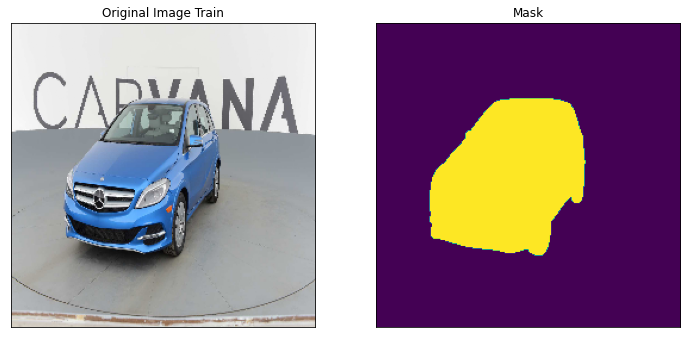

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 12))
ax1, ax2 = axes
ax1.imshow(images_train[0]);
#ax1.set_grid(True);
ax1.set_xticks([]);
ax1.set_yticks([]);
ax1.set_title("Original Image Train")

ax2.imshow(np.squeeze(images_train_target[0]));
#ax2.set_grid(True);
ax2.set_xticks([]);
ax2.set_yticks([])
ax2.set_title("Mask")

Text(0.5, 1.0, 'Mask')

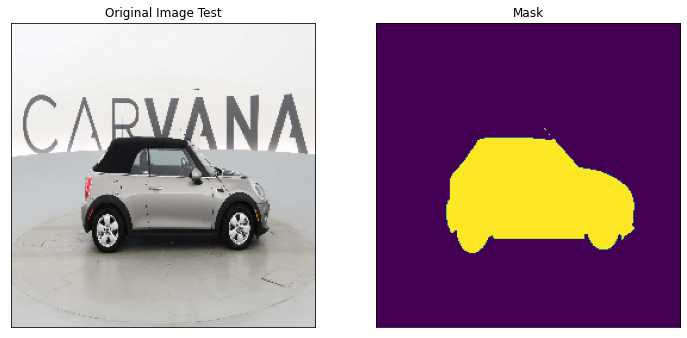

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 12))
ax1, ax2 = axes
ax1.imshow(images_test[0]);
#ax1.set_grid(True);
ax1.set_xticks([]);
ax1.set_yticks([]);
ax1.set_title("Original Image Test")

ax2.imshow(np.squeeze(images_test_target[0]));
#ax2.set_grid(True);
ax2.set_xticks([]);
ax2.set_yticks([])
ax2.set_title("Mask")

## 3. Задание гиперпараметров и функций потерь

### 3.1. Определение гиперпараметров

In [57]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

### 3.2. Определение функции потерь (IoU): https://www.kaggle.com/gargkaman7/semantic-segemntation 

In [58]:
def iou_loss_score(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

In [59]:
def iou(y_true, y_pred):
  smooth=1
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return score

In [60]:
def iou_loss(y_true, y_pred):
    loss = 1 - iou(y_true, y_pred)
    return loss

### 3.3.Определение метрики и функции потерь (BCE, DICE):  https://colab.research.google.com/github/MarkDaoust/models/blob/segmentation_blogpost/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb#scrollTo=_SsQjuN2dWmU

In [13]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [14]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [15]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

## 4. Определение структуры U-net

### 4.1. Создание U-net с нуля: https://www.kaggle.com/gargkaman7/semantic-segemntation

In [35]:
# Заменить elu на siwsh и mish

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

### 4.2. Создание U-net на основе предтренированной Efficient net

Основа взята отсюда: https://www.tensorflow.org/tutorials/images/segmentation. Заменен энкодер и переработан декодер.

In [61]:
! pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-sdyhww25
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-sdyhww25
  Created wheel for efficientnet: filename=efficientnet-1.1.0-cp36-none-any.whl size=18398 sha256=03172af8e2e782328b1695edf49538d35a90f9d85f13421cfb0e39704f2d44e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-8n5lp15o/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.0
    Uninstalling efficientnet-1.1.0:
      Successfully uninstalled efficientnet-1.1.0


In [62]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-q_nyoyua
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-q_nyoyua
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0a6d7c01681eaca47d5d6237bb23a180a96ae1bf_-cp36-none-any.whl size=134253 sha256=2f43b21e0a929feeffd430bc7659bba87872d2abc8715b7c45dc1b2bb5668283
  Stored in directory: /tmp/pip-ephem-wheel-cache-ps1ejg7a/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
Requirement already up-to-date: tfds-nightly in /usr/local/lib/python3.6/dist-packages (3.2.0.dev202007140105)


In [63]:
from tensorflow_examples.models.pix2pix import pix2pix

In [64]:
import efficientnet.tfkeras as efn

In [65]:
model = efn.EfficientNetB4(weights='imagenet', input_shape=[256, 256, 3], include_top=False)

In [66]:
model.trainable = False

In [67]:
#model.summary()

In [68]:
# Соответствует слоям с меньшим количеством каналов 

up_stack = [
    pix2pix.upsample(224, 3),  # 8x8 -> 16x16
    pix2pix.upsample(80, 3),  # 16x16 -> 32x32
    pix2pix.upsample(48, 3),  # 32x32 -> 64x64
    pix2pix.upsample(32, 3),   # 64x64 -> 128x128
]

In [69]:
layer_names = [
    'stem_conv',     # 128x128 48
    'block2b_add',   # 64x64 32
    'block3b_add',   # 32x32 56
    'block5b_add',   # 16x16 160
    #'block6b_add ',  # 8x8 272
    'top_activation',      # 8x8 1792 (top)
]

In [70]:
layers = [model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=model.input, outputs=layers)

down_stack.trainable = False

In [80]:
# Замутить хитрую инициализацию весов и swish, mish

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]

  #x = tf.keras.layers.Conv2D(1024, 3, strides=(1, 1), padding='same', activation='relu')(x)
  x = tf.keras.layers.Conv2D(512, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)
  x = tf.keras.layers.Conv2D(256, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)

  x = up_stack[0](x)
  x = tf.keras.layers.Concatenate()([x, skips[3]])
  x = tf.keras.layers.Conv2D(128, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)


  x = up_stack[1](x)
  x = tf.keras.layers.Concatenate()([x, skips[2]])
  x = tf.keras.layers.Conv2D(64, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)


  x = up_stack[2](x)
  x = tf.keras.layers.Concatenate()([x, skips[1]])
  x = tf.keras.layers.Conv2D(64, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)


  x = up_stack[3](x)
  x = tf.keras.layers.Concatenate()([x, skips[0]])
  x = tf.keras.layers.Conv2D(32, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)
  x = tf.keras.layers.Conv2D(16, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)


  # This is the last layer of the model
  #last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2,padding='same')  #64x64 -> 128x128

  
  last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2,padding='same', activation='sigmoid')  #128x128 -> 256x256
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [81]:
OUTPUT_CHANNELS = 1
model = unet_model(OUTPUT_CHANNELS)

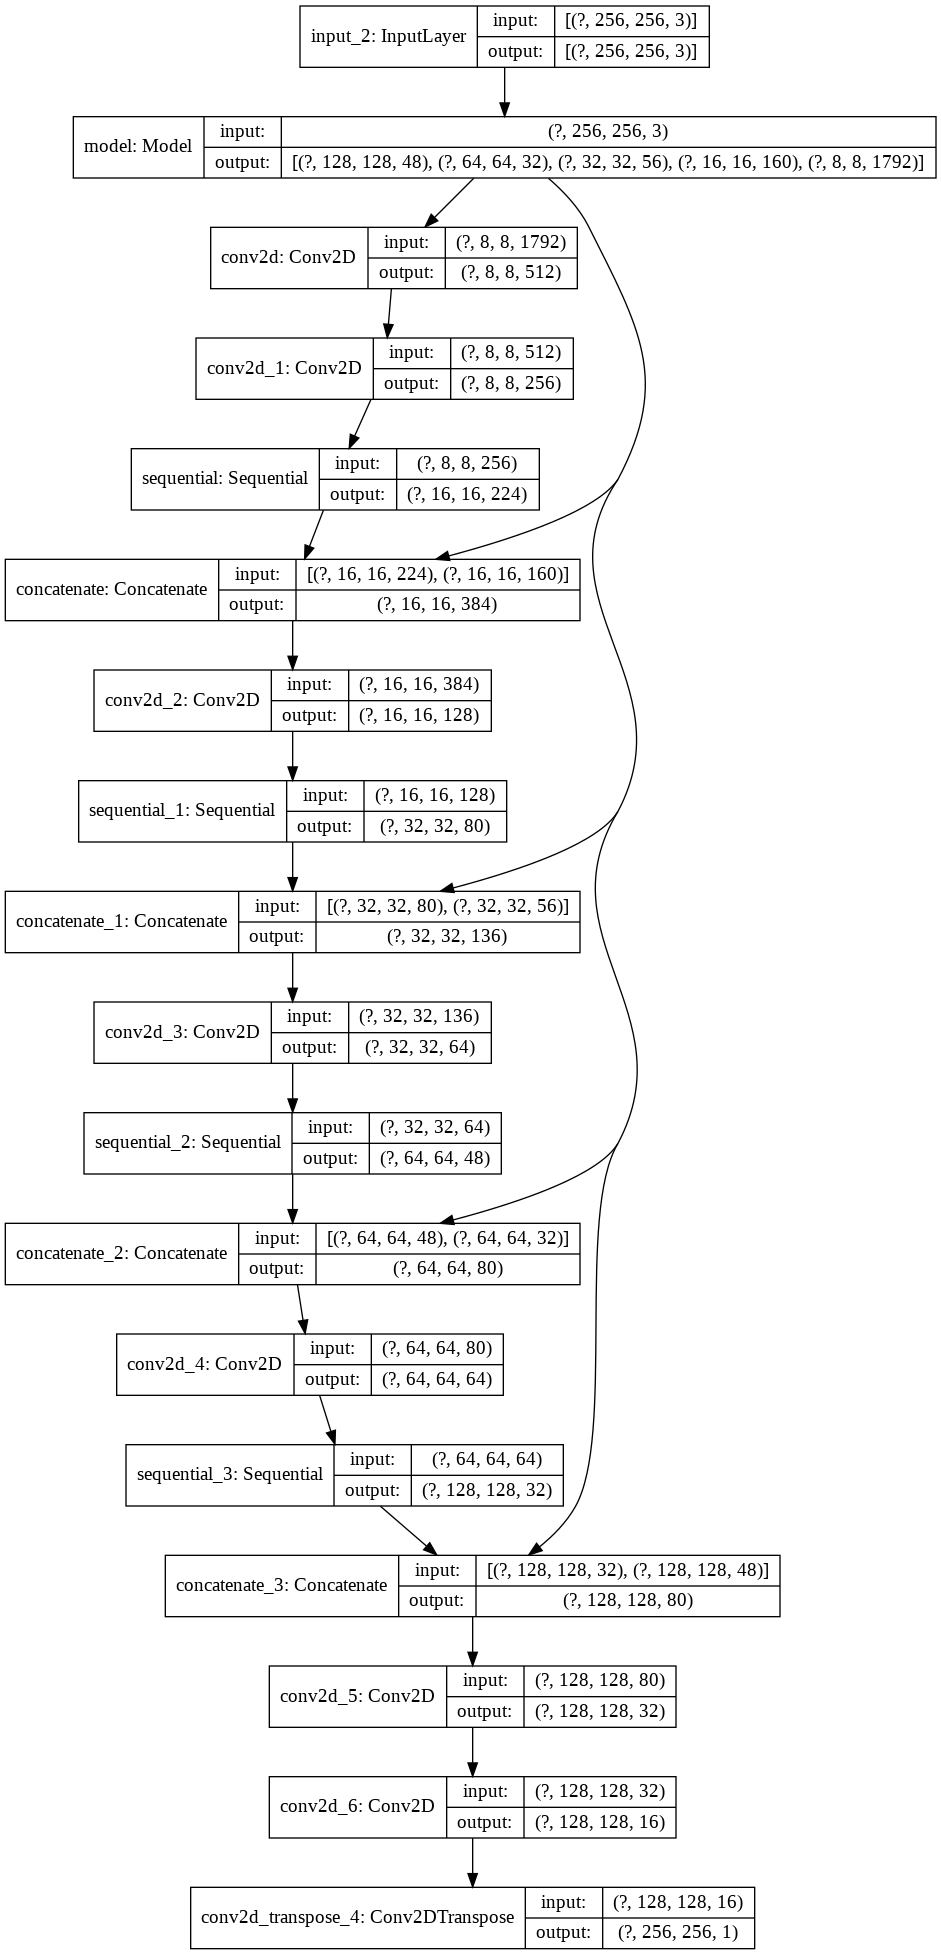

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

### 4.3.  Создание U-net на основе предтренированной Efficient net и декодером из п 4.1.

In [13]:
! pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-wv586xcg
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-wv586xcg
  Created wheel for efficientnet: filename=efficientnet-1.1.0-cp36-none-any.whl size=18398 sha256=fc9d98dd04f0a2c803fca83586303dd30f3ed04926501a3d281259fc2c23850f
  Stored in directory: /tmp/pip-ephem-wheel-cache-58gkgk_9/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.0
    Uninstalling efficientnet-1.1.0:
      Successfully uninstalled efficientnet-1.1.0


In [14]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-rwruz3fs
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-rwruz3fs
  Created wheel for tensorflow-examples: filename=tensorflow_examples-e8ebbcd9a4b911e39e8506aad4c9342284c248c0_-cp36-none-any.whl size=134434 sha256=25f216b80cb0007777559717da9236fdf142626f9599d50875560e64ea86fc88
  Stored in directory: /tmp/pip-ephem-wheel-cache-atbso0cs/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
Requirement already up-to-date: tfds-nightly in /usr/local/lib/python3.6/dist-packages (3.2.0.dev202007130106)


In [15]:
import efficientnet.tfkeras as efn

In [16]:
model = efn.EfficientNetB4(weights='imagenet', input_shape=[256, 256, 3], include_top=False)

In [17]:
model.trainable = False

In [18]:
layer_names = [
    'stem_conv',     # 128x128 48
    'block2b_add',   # 64x64 32
    'block3b_add',   # 32x32 56
    'block5b_add',   # 16x16 160
    #'block6b_add ',  # 8x8 272
    'top_activation',      # 8x8 1792 (top)
]

In [19]:
layers = [model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=model.input, outputs=layers)

down_stack.trainable = False

In [20]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]

  x = tf.keras.layers.Conv2D(512, 3, activation='elu', kernel_initializer='he_normal', padding='same')(x)
  x = tf.keras.layers.Conv2D(256, 3, activation='elu', kernel_initializer='he_normal', padding='same')(x)

  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (x)
  x = tf.keras.layers.Concatenate()([x, skips[3]])
  x = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (x)
  x = Dropout(0.2) (x)
  x = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (x)

  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (x)
  x = tf.keras.layers.Concatenate()([x, skips[2]])
  x = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (x)
  x = Dropout(0.2) (x)
  x = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (x)

  x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (x)
  x = tf.keras.layers.Concatenate()([x, skips[1]])
  x = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (x)
  x = Dropout(0.1) (x)
  x = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (x)

  x = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (x)
  x = tf.keras.layers.Concatenate()([x, skips[0]])
  x = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (x)
  x = Dropout(0.1) (x)
  x = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (x)
  x = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (x)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (x)


  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [21]:
OUTPUT_CHANNELS = 1
model = unet_model(OUTPUT_CHANNELS)

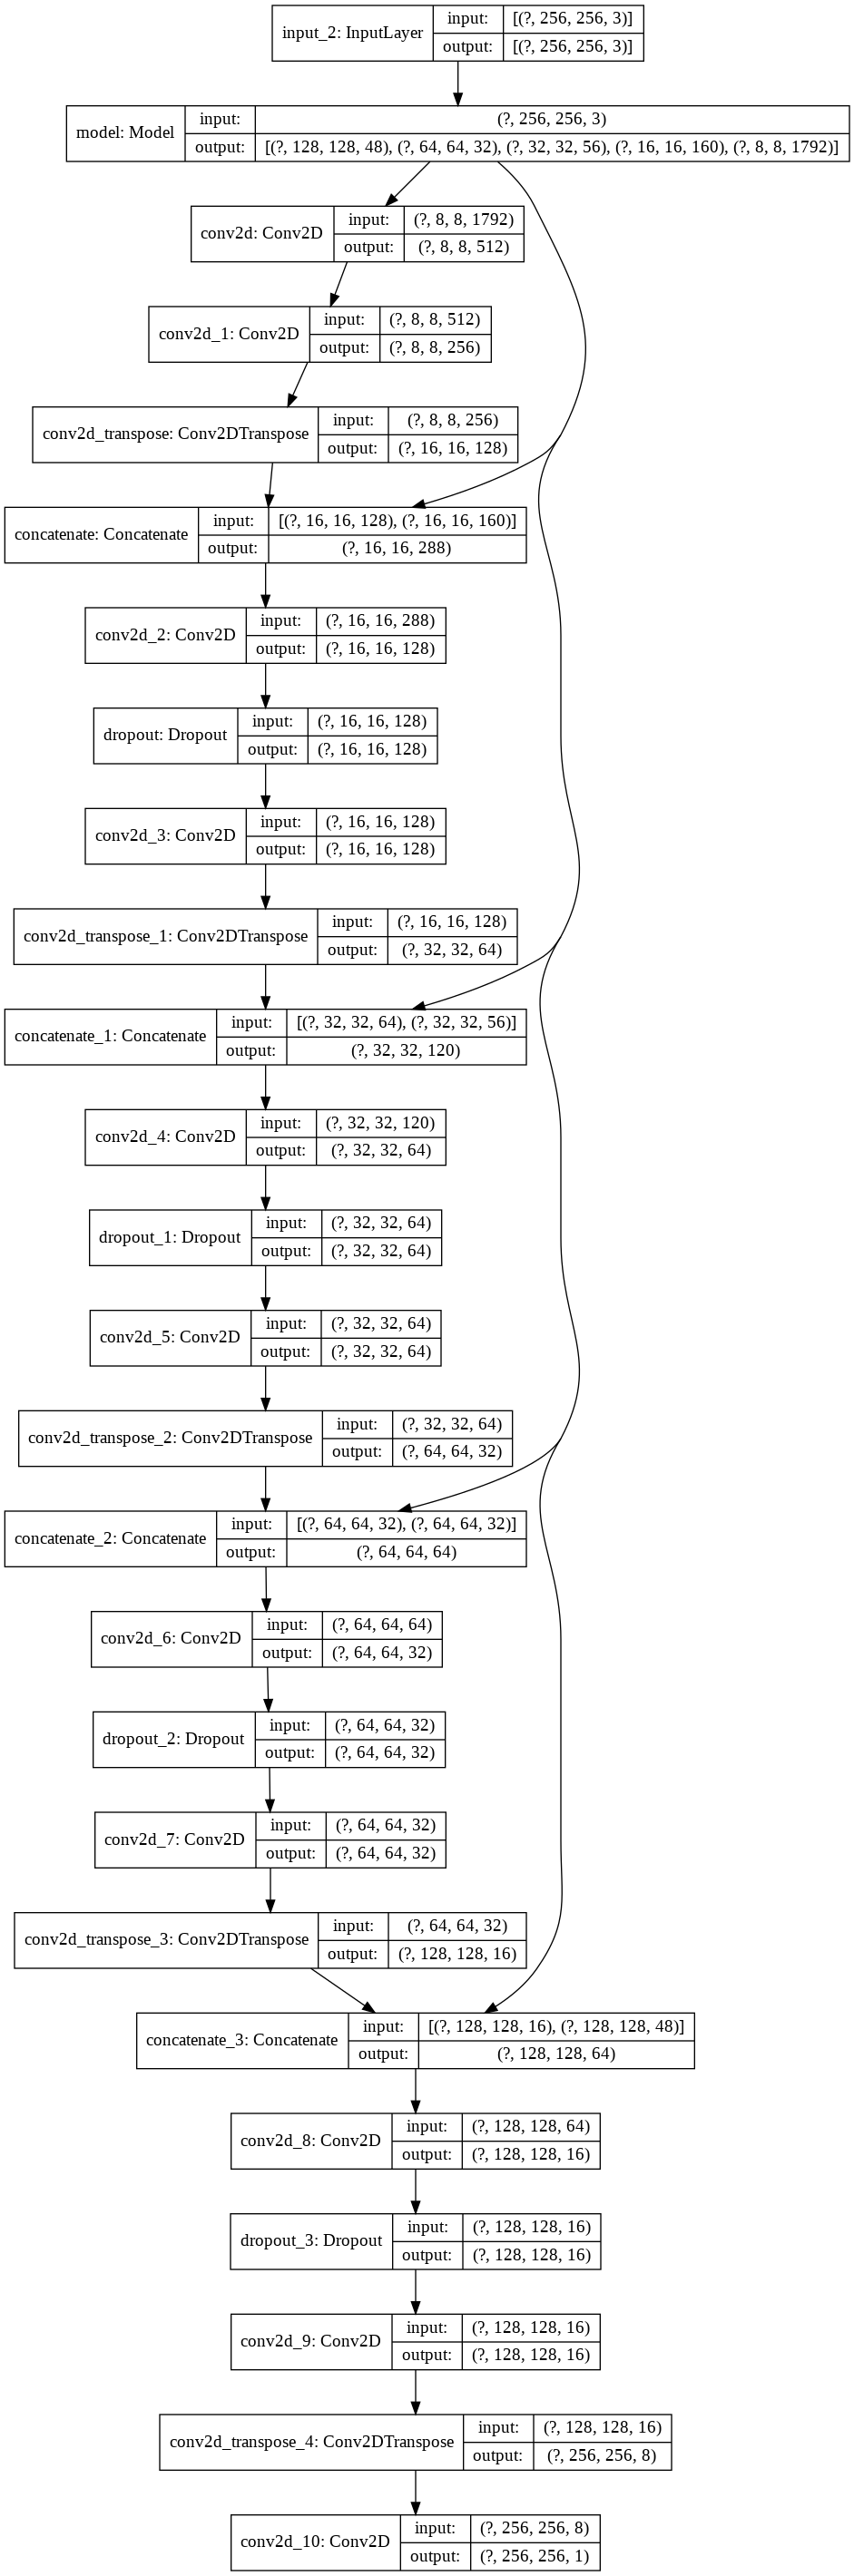

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 5. Компиляция и тренировка

In [82]:
# Попробовать разные функции потерь, метрики качества и оптимизаторы. Вывод графиков точности при обучении.
# Сделать вывод результатов после каждой эпохи
# Попробовать скрестить 2 unet'а с целью уменьшения параметров
# Эксперименты на разных разрешениях и аугментация

# Unet'ы по 4.3 и 4.2 сопоставимы по точности. По 4.1 точность медленнее растет


#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou_loss_score])
#model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou_loss_score])

model.fit(images_train, images_train_target, epochs = 10, batch_size = 64, validation_data = (images_test, images_test_target))

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Model)                 [(None, 128, 128, 48 17673816    input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 8, 8, 512)    8258048     model_4[4][4]                    
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 8, 8, 256)    1179904     conv2d_35[0][0]                  
____________________________________________________________________________________________

## 6. Проверка результатов

In [21]:
preds_train = (model.predict(images_train[0][None]) > 0.5).astype(np.uint8)
fig, axes = plt.subplots(ncols=3, figsize=(12, 12))
ax1, ax2, ax3 = axes
ax1.imshow(images_train[0]);
#ax1.set_grid(True);
ax1.set_xticks([]);
ax1.set_yticks([]);
ax1.set_title("Original Image Train")

ax2.imshow(np.squeeze(images_train_target[0]));
#ax2.set_grid(True);
ax2.set_xticks([]);
ax2.set_yticks([])
ax2.set_title("Mask")


ax3.imshow(np.squeeze(preds_train[0]));
#ax2.set_grid(True);
ax3.set_xticks([]);
ax3.set_yticks([])
ax3.set_title("Predicted Mask")

NameError: ignored

Text(0.5, 1.0, 'Predicted Mask')

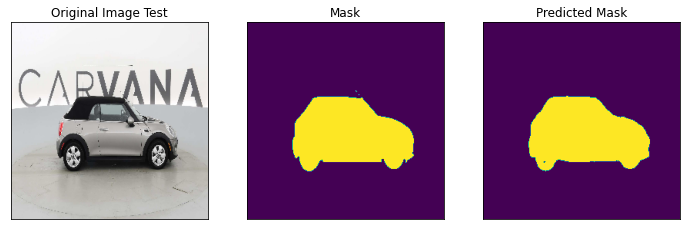

In [62]:
preds_test = (model.predict(images_test[0][None]) > 0.5).astype(np.uint8)
fig, axes = plt.subplots(ncols=3, figsize=(12, 12))
ax1, ax2, ax3 = axes
ax1.imshow(images_test[0]);
#ax1.set_grid(True);
ax1.set_xticks([]);
ax1.set_yticks([]);
ax1.set_title("Original Image Test")

ax2.imshow(np.squeeze(images_test_target[0]));
#ax2.set_grid(True);
ax2.set_xticks([]);
ax2.set_yticks([])
ax2.set_title("Mask")


ax3.imshow(np.squeeze(preds_test[0]));
#ax2.set_grid(True);
ax3.set_xticks([]);
ax3.set_yticks([])
ax3.set_title("Predicted Mask")